In [1]:
pip uninstall -y gensim

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Successfully uninstalled gensim-3.6.0


<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Supervized learning with tf-idf and score
        </h1>
    </div>
</div>

- **[Preprocessing](#pre)**

- **[GridSearch](#gri)**

- **[Resultat](#re)**

- **[Resultat par modeles](#mo)**




Nous avons selectionner le score dans le resultats de nos requetes, la question est : "est ce que les scores recuperer vont nous permettre d ameliorer nos modeles en l ajoutant ?"

Nous allons donc effectuer le meme test que le notebook precedant , mais en ajoutant le score dans notre pipeline, ce test est interessant car il melange les donnees chiffrees des textes grace a TF IDF et des scores donnees par les internautes.

Le modèle Bag of Words apprend un vocabulaire à partir de tous les documents, puis modélise chaque document en comptant le nombre de fois où chaque mot apparaît, convertissant donc les données textuelles en données numériques.

Nos données ayant déjà été cleanées et tokenisées , nous allons utiliser le module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer. Cela aura pour effet de pondérer la fréquence d'apparition des mots par un indicateur de similarité (si ce mot est commun ou rare dans tous les documents). Dans cette partie, nous allons éliminer les mots qui apparaissent dans plus de 60% des documents (max_df = 0.6).

la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique.

Nous utiliserons aussi la methode <code>oneVersusRest</code> classifier

Pour préparer nos targets, nous allons utiliser MultiLabelBinarizer de Scikit-Learn puisque nos Tags sont multiples.



Nous allons tester plusieurs métriques sur les modèles  :

- Accuracy score 
- F1 score :
- Jaccard similarity score :
- Recall :
- Precision :


Nous allons egalement tester les taux de predictions rempli, pour choisir les modeles finaux

In [ ]:
# pip install  gensim===3.2.1

In [ ]:
# pip uninstall pyLDAvis

In [ ]:
# pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user

In [3]:
# Import Python libraries
import os
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
import unicodedata
from bs4 import BeautifulSoup
# from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from IPython.core.display import display, HTML
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import timeit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, recall_score,precision_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
import joblib

In [4]:
from sklearn.multioutput import ClassifierChain,MultiOutputRegressor,MultiOutputClassifier,RegressorChain
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet,RidgeClassifier
from sklearn.svm import LinearSVC
from scipy.stats import reciprocal, uniform

In [5]:
from google.colab import drive
drive.mount('/content/ShardDrives/', force_remount=True)

Mounted at /content/ShardDrives/


In [7]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)

In [8]:

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
# !python -m pip install -U gensim

In [9]:
# import utils own functions
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [10]:
data = pd.read_csv("/content/ShardDrives/MyDrive/nlp/stackoverflow_cleaned.csv",sep=";", index_col=0,
                               converters={
                                   "tags": literal_eval,
                                   "text": literal_eval
                               }
                  )
data.head()

,tags,full_text,text,score
Id,,,,
5767325,"[javascript, arrays]",How can I remove a specific item from an array...,"[item, array, array, number, method, element, ...",10385
7244321,[git],How do I update or sync a forked repository on...,"[repository, github, project, fix, pull, reque...",4359
8710619,[java],"Why don't Java's +=, -=, *=, /= compound assig...","[java, compound, assignment, operator, today, ...",3779
6245570,[git],How to get the current branch name in Git? I'm...,"[branch, name, git, subversion, background, br...",3372
8467424,[bash],Echo newline in Bash prints literal \n In Bash...,"[echo, newline, bash, print, bash, newline, ne...",3050


<a name='pre'></a>

<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Preprocessing du textes et du score
        </h1>
    </div>
</div>

In [11]:
# text and numeric classes that use sklearn base libaries
from sklearn.base import BaseEstimator, TransformerMixin
class TextTransformer(BaseEstimator, TransformerMixin):
    """
    Transform text features
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberTransformer(BaseEstimator, TransformerMixin):
    """
    Transform numeric features
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

Afin que la modelisation soit possibles, nous avons utilise <code>FeatureUnion</code> qui permet de regrouper nos deux pipelines (texte et chiffre)

In [12]:
tfidf = Pipeline([
                ('transformer', TextTransformer(key='text')),  
                ('tfidf', TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False,
                             ngram_range=(1, 3)
                                         ))
            ])

score = Pipeline([
                ('transformer', NumberTransformer(key='score')),
                ])

features = FeatureUnion([
                      ('texte', tfidf),
                      ('score', score),
                      ])

In [13]:
X = data[["text","score"]]
y = data['tags']
multilabel_binarizer = MultiLabelBinarizer()
y_encoded = multilabel_binarizer.fit_transform(y)



X_train, X_test, y_train , y_test = train_test_split(X , y_encoded, test_size = 0.2, random_state= 0)

test de la pipeline

In [ ]:
clf = RandomForestClassifier()
# unite the features and classfier together
pipe = Pipeline([                 
                 ('features', features),
                 ('std',StandardScaler(with_mean=False)),
                 ('clf',clf)
                 ])
pipe.fit(X_train[0:100], y_train[0:100])

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('texte',
                                                 Pipeline(steps=[('transformer',
                                                                  TextTransformer(key='text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(lowercase=False,
                                                                                  max_df=0.6,
                                                                                  min_df=0.005,
                                                                                  ngram_range=(1,
                                                                                               3),
                                                                                  preprocessor=<built-in method join of str object at 0x7f7a70f8bef0>))])),
                   

In [ ]:
multilabel_binarizer.classes_

array(['.net', 'algorithm', 'android', 'angular', 'angularjs', 'arrays',
       'asp.net', 'bash', 'c', 'c#', 'c++', 'c++11', 'css', 'gcc', 'git',
       'google-chrome', 'haskell', 'html', 'ios', 'iphone', 'java',
       'java-8', 'javascript', 'jquery', 'json', 'language-lawyer',
       'linux', 'macos', 'multithreading', 'mysql', 'node.js',
       'objective-c', 'performance', 'php', 'pointers', 'python',
       'python-3.x', 'r', 'reactjs', 'regex', 'ruby', 'ruby-on-rails',
       'sql', 'sql-server', 'string', 'swift', 'typescript',
       'visual-studio', 'windows', 'xcode'], dtype=object)

In [ ]:
X.shape , y.shape

((93701,), (93701,))

<a name='gri'></a>

<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          gridsearch
        </h1>
    </div>
</div>


Nous allons tester respectivement les modeles suivants avec GridSearchCV:

<code> 
    'multinomial': MultinomialNB(),
    'SGDClassifier': SGDClassifier(),
    'logistic': LogisticRegression(),
    'randomForest': RandomForestClassifier(),
    'RidgeClassifier': RidgeClassifier()
</code>    



Dans cette partie, nous allons tester differents algorithme dans un gridSearchCv et oneVSRest avec les metriques

     - accuracy
     - f1
     - jaccard
     - recall
     - precision
     
     
Pour notre modelisation , nous allons tenter de tester des modeles de classification disponibles , ainsi que les comparer entre eux par nos metriques.

Pour cela nous avons creer une classe <code>nlpEstimatorAlgo</code> recuperant une liste de dictionnary (nom modele --> Modele de regression a tester), celui ci les testera un a un dans un GRIDSEARCHCV et renverra les resultats      


In [18]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import RidgeCV
from sklearn import linear_model

class nlpEstimatorAlgo:

    
    def __init__(self, models, params,useLog=True):
        self.models = models
        self.keys = models.keys()
        self.params = params
        self.grid_searches = {}
        self.useLog = useLog
        self.bestParams = {}
        self.scorer = {}
        self.cv_results = {}
        self.scoring = {
                        "accuracy" : "accuracy",
                        "f1" : "f1", 
                        "jaccard" : "jaccard",
                        "recall" : "recall",
                        "precision":"precision"
                        }
#         self.kfold = KFold(n_splits=5, random_state=0) 
        self.kfold = KFold(n_splits=5) 
#         self.kfold = StratifiedKFold(n_splits=5)
       
    
    def fit(self, X_train, y_train):
        starttotaltime = timeit.default_timer()
        for model_name in self.keys:
            print('Running GridSearchCV for %s.' % model_name)     
            starttime = timeit.default_timer()
            model = self.models[model_name]
            params = self.params[model_name]
            print('training model',model)  
            #GridSearchCV
            #RandomizedSearchCV
                  
            
            
            pipeline =  Pipeline([
                ('features', features),
                ('std',StandardScaler(with_mean=False)),
                (model_name,OneVsRestClassifier(model)), 
#                 (model_name,ClassifierChain(model)), 
#                 (model_name,MultiOutputClassifier(model)), 
#                 (model_name,RegressorChain(model)), 
            ])
            
            grid_search = GridSearchCV(
                                    pipeline, 
                                    params,
                                    # scoring = self.scoring,
                                    # scoring = "f1_weighted",
                                    scoring = {
                                                "f1_weighted" : "f1_weighted", 
                                                "accuracy" : "accuracy",
                                                },
                                    return_train_score = True,
                                    # refit=True,
                                    refit="f1_weighted",
                                    cv = self.kfold,
                                    n_jobs=-1
                                    )
            
#             print(grid_search.get_params().keys())
            if model_name == 'randomForest':
              grid_search.fit(X_train[0:7000], y_train[0:7000])
            else:
              grid_search.fit(X_train, y_train)
            self.bestParams[model_name] = grid_search.best_params_
            self.scorer[model_name] = grid_search.best_estimator_
            self.grid_searches[model_name] = grid_search
            self.cv_results[model_name] = grid_search.cv_results_
            
            
            elapsed = timeit.default_timer() - starttime
            print('training {} model done'.format(model_name))
            print("elapsed time {:.2f}s".format(elapsed))
        print('All training done.')
        elapsed = timeit.default_timer() - starttotaltime
        print("total time {:.2f}s".format(elapsed))
        
        
    def getBestParams(self):
        return self.bestParams
    
    def showBestParams(self,useindex=False):
        frames =[]
        result = pd.DataFrame()
        for name, bestParams in self.bestParams.items():      
            frame = pd.DataFrame()
            frame['estimator'] = [name]  
            frame['best_params'] = [bestParams]
            frames.append(frame)
        result = pd.concat(frames) 
        result = result.reset_index()
        if(useindex):
            result.set_index('estimator', inplace=True)
        result = result.drop([ 'index'], 1)
        return result     
    
    def getGetScorer(self):
        return self.scorer 
    
    def getCvResults(self):
        return sel.cv_results_
    
    def getPredictionsResult(self, name, X_test):
      # Predict
      result = pd.DataFrame()
      y_test_predicted_labels = self.grid_searches[name].predict(X_test)
      result['True_Tag'] = multilabel_binarizer.inverse_transform(y_test)
      result['predicted_Tag'] = multilabel_binarizer.inverse_transform(y_test_predicted_labels)
      return result

    def getUnTaggedPredictionsByModel(self, X_test):
      frames =[]
      result = pd.DataFrame()
      for name, grid_search in self.grid_searches.items():  
        frame = pd.DataFrame()
        y_test_predicted_labels = grid_search.predict(X_test)
        tags_per_row = y_test_predicted_labels.sum(axis=1)
        null_rate = round(((tags_per_row.size - np.count_nonzero(tags_per_row))/tags_per_row.size)*100,2)
        frame['estimator'] = [name]  
        frame['untaged'] = str(null_rate) +'%'
        frames.append(frame)
      result = pd.concat(frames)   
      return result
    
    def getClassificationReport(self,name, y_test, X_test):                
        y_test_predicted_labels = self.grid_searches[name].predict(X_test)                
        print('accuracy model {} : {}'.format(name, accuracy_score(y_test_predicted_labels, y_test)))                
        report_dict = classification_report(y_test, y_test_predicted_labels, output_dict=True, target_names=multilabel_binarizer.classes_)
        return pd.DataFrame(report_dict).T

    def savemodels(self):
      joblib.dump(tfidf,'/content/ShardDrives/MyDrive/nlp/tfidf/tfidf_vectorizer.pkl')
      joblib.dump(multilabel_binarizer,'/content/ShardDrives/MyDrive/nlp/tfidf/multilabel_binarizer.pkl')

      for name, grid_search in self.grid_searches.items():  
        joblib.dump(grid_search,'/content/ShardDrives/MyDrive/nlp/tfidf/'+name+'-tfidf.pkl')



     #renvoie les meilleurs resulats par modele contenu tester sur les variables test
    def getBestModeleScore_scorePrediction(self,useIndex=False):
        frames =[]
        result = pd.DataFrame()
        for name, grid_search in self.grid_searches.items():      
            frame = pd.DataFrame()
            #grid_search.predict(X_test) is equivalent to grid_search.best_estimator_.predict(X_test)
            # Inverse transform
            y_pred = grid_search.predict(X_test) 
            frame['estimator'] = [name]  
            frame['accuracy'] = np.round((accuracy_score(y_test, y_pred)), 5)
            frame['f1_macro'] = np.round(f1_score(y_test, y_pred, average="macro"), 3)
            frame['f1_micro'] = np.round(f1_score(y_test, y_pred, average="micro"), 3)
            frame['jaccard'] = np.round(jaccard_score(y_test, y_pred, average="weighted"), 3)
            frame['recall'] = np.round(recall_score(y_test, y_pred, average="weighted"), 3)
            frame['precision'] = np.round(precision_score(y_test, y_pred, average="weighted"), 3)                            
            frames.append(frame)
        result = pd.concat(frames) 
        result = result.reset_index()
        if(useIndex):
            result.set_index('estimator', inplace=True)
        result = result.drop([ 'index'], 1)
        return result  
    
    #affiche les meilleurs resulats par modele contenu tester sur les variables test
    def getBestModeleScore_graphpredictions(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_scorePrediction(True).plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs predictions par modeles apres hyperparametrisations')
        plt.show()      
    
#     Generate 3 plots: the test and training learning curve, the training
#     samples vs fit times curve, the fit times vs score curve.
    def getLearningCurveByName(self,model_name,X_train,y_train):
        ## Results from grid search
        grid = self.grid_searches[model_name]
        title = "learning curve for model {}".format(model_name)
        estimator = grid.best_estimator_
        estimator = grid.best_estimator_
        utils.plot_learning_curve(
            estimator, title, X_train, y_train,ylim=None, cv=self.kfold, n_jobs=4
        )        
        plt.show()    
        
    #Show validation between real values vs predicted values        
    def showPredictionbyName(self,name,target,X_train,y_train):
        plot_cross_val_predi(self.grid_searches[name].best_estimator_, name, target, X_train, y_train, cv=self.kfold)          

    
models = {   
        'multinomial':MultinomialNB(),
        'SGDClassifier':SGDClassifier(),
        'logistic': LogisticRegression(),
        'randomForest': RandomForestClassifier(),
        'RidgeClassifier' : RidgeClassifier()
}

params_models = {

            'multinomial':{
                'multinomial__estimator__alpha': [1, 1e-1, 1e-2],
            },
            'SGDClassifier':{
                'SGDClassifier__estimator__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
                'SGDClassifier__estimator__max_iter': [1000], # number of epochs
                'SGDClassifier__estimator__loss': ['log'], # logistic regression,
                'SGDClassifier__estimator__penalty': ['l1','l2'],
                'SGDClassifier__estimator__n_jobs': [-1]
                },
            'logistic': 
                            {
                              "logistic__estimator__C": [100, 10, 1.0, 0.1],
                              "logistic__estimator__penalty": ["l1", "l2"],
                              "logistic__estimator__dual": [False],
                              "logistic__estimator__solver": ["liblinear"]
                            },
            'randomForest' :{
                              "randomForest__estimator__max_depth": [5, 25, 50],
                              "randomForest__estimator__min_samples_leaf": [1, 5, 10],
                              "randomForest__estimator__class_weight": ["balanced"]
                             },  
    
            'RidgeClassifier': {                
                        'RidgeClassifier__estimator__max_iter': [1500,2000,3000],
                        'RidgeClassifier__estimator__alpha': np.arange(0.1, 1, .2).tolist(),        
                        'RidgeClassifier__estimator__solver' :['auto', 'cholesky']
                    },                
               
}     

algo_estimator = nlpEstimatorAlgo(models, params_models,True)
algo_estimator.fit(X_train,y_train)

Running GridSearchCV for multinomial.
training model MultinomialNB()
training multinomial model done
elapsed time 49.80s
Running GridSearchCV for SGDClassifier.
training model SGDClassifier()
training SGDClassifier model done
elapsed time 644.22s
Running GridSearchCV for logistic.
training model LogisticRegression()
training logistic model done
elapsed time 674.94s
Running GridSearchCV for randomForest.
training model RandomForestClassifier()
training randomForest model done
elapsed time 135.51s
Running GridSearchCV for RidgeClassifier.
training model RidgeClassifier()
training RidgeClassifier model done
elapsed time 206.77s
All training done.
total time 1711.24s


<a name='re'></a>

<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          resultat
        </h1>
    </div>
</div>

les modeles logistic et SGDCClassifier donnent les meilleurs resultats sur nos metriques

In [19]:
algo_estimator.getBestModeleScore_scorePrediction()

,estimator,accuracy,f1_macro,f1_micro,jaccard,recall,precision
0,multinomial,0.01905,0.261,0.305,0.249,0.844,0.265
1,SGDClassifier,0.33557,0.522,0.594,0.427,0.484,0.743
2,logistic,0.34758,0.544,0.610,0.444,0.500,0.761
3,randomForest,0.25543,0.500,0.583,0.426,0.615,0.576
4,RidgeClassifier,0.26039,0.416,0.501,0.334,0.358,0.792


On constate que nos scores sont legerement meilleurs avec les scores que sans.(surtout pour le modele SGDC)
Cependant , le but du programm est d effectuer des predictions sur uniquement des phrases sans les scores...

Mais cette exercice nous a permis de comprendre quelques principes de combinaisons NLP avec des features numeriques



Les modeles logistic et randomForest ont les predictions les plus remplies

In [20]:
algo_estimator.getUnTaggedPredictionsByModel(X_test)

,estimator,untaged
0,multinomial,0.21%
0,SGDClassifier,28.58%
0,logistic,28.33%
0,randomForest,13.32%
0,RidgeClassifier,46.97%


In [ ]:
algo_estimator.savemodels()

In [ ]:
algo_estimator.getBestModeleScore_scorePrediction().to_csv("/content/ShardDrives/MyDrive/nlp/tfidf/ntdif_models_resutls.csv")

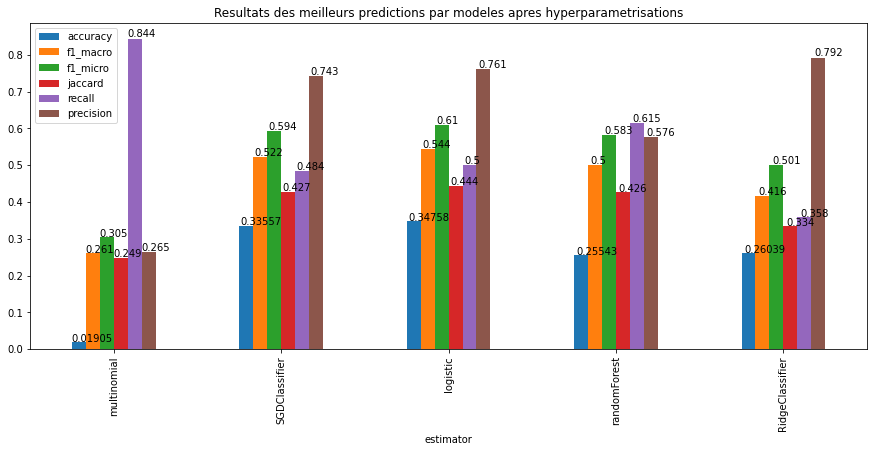

In [21]:
algo_estimator.getBestModeleScore_graphpredictions()

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [ ]:
algo_estimator.showBestParams()

,estimator,best_params
0,multinomial,{'multinomial__estimator__alpha': 0.01}
1,SGDClassifier,"{'SGDClassifier__estimator__alpha': 0.0001, 'SGDClassifier__estimator__loss': 'log', 'SGDClassifier__estimator__max_iter': 1000, 'SGDClassifier__estimator__n_jobs': -1, 'SGDClassifier__estimator__penalty': 'l2'}"
2,logistic,"{'logistic__estimator__C': 1.0, 'logistic__estimator__dual': False, 'logistic__estimator__penalty': 'l1', 'logistic__estimator__solver': 'liblinear'}"
3,randomForest,"{'randomForest__estimator__class_weight': 'balanced', 'randomForest__estimator__max_depth': 50, 'randomForest__estimator__min_samples_leaf': 5}"
4,RidgeClassifier,"{'RidgeClassifier__estimator__alpha': 0.1, 'RidgeClassifier__estimator__max_iter': 1500, 'RidgeClassifier__estimator__solver': 'auto'}"


<a name='mo'></a>

<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Resultat par modeles
        </h1>
    </div>
</div>

Dans cette partie nous allons analyser plus en detail chaque modele.

- La prediction de tag realiser par le modele vs tag reel
    
- la learning curve du modele (si il y a Under/Over fitting)
    
-  ainsi que la classification report par tag
    

Classificateur Naive Bayes pour les modèles multinomiaux.

Le classificateur multinomial Naive Bayes convient à la classification avec des caractéristiques discrètes (par exemple, le nombre de mots pour la classification de texte). La distribution multinomiale nécessite normalement un nombre entier de caractéristiques. Cependant, en pratique, les comptages fractionnaires tels que tf-idf peuvent également fonctionner.

,True_Tag,predicted_Tag
3854,"(android,)","(.net, android, angularjs, ios, iphone, javasc..."
6583,"(angular, typescript)","(angular, angularjs, asp.net, c#, json, node.j..."
11522,"(html, javascript)","(angular, angularjs, asp.net, css, google-chro..."
175,"(angularjs, javascript)","(android, angular, angularjs, ios, iphone, jav..."
12173,"(ios, iphone)","(android, css, html, ios, iphone, jquery, obje..."
18413,"(java,)","(algorithm, arrays, c, c++, haskell, java, jav..."
18586,"(javascript,)","(c, c#, c++, c++11, haskell, java, java-8, jav..."
8592,"(python,)","(angular, angularjs, google-chrome, javascript..."
9887,"(c#,)","(android, ios, iphone, windows)"
13046,"(git,)","(angular, git, json, node.js, ruby-on-rails, t..."


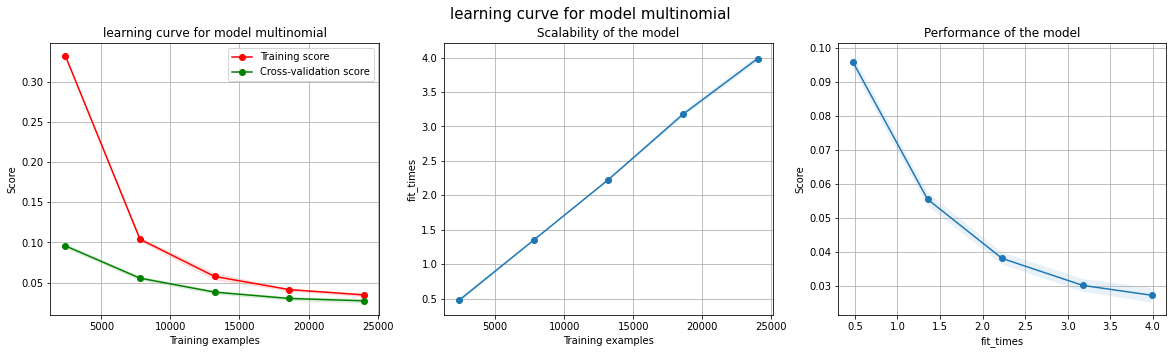

accuracy model multinomial : 0.019049143588922682


,precision,recall,f1-score,support
.net,0.121035,0.733558,0.207786,593.0
algorithm,0.204860,0.910615,0.334473,537.0
android,0.430566,0.858608,0.573526,1365.0
angular,0.095652,0.846154,0.171875,247.0
angularjs,0.079928,0.868293,0.146382,205.0
arrays,0.110840,0.831050,0.195594,438.0
asp.net,0.077802,0.834906,0.142340,212.0
bash,0.118390,0.867052,0.208333,173.0
c,0.245105,0.871417,0.382596,1221.0
c#,0.346943,0.749767,0.474376,2142.0


In [22]:
display(algo_estimator.getPredictionsResult( "multinomial", X_test).sample(10))
algo_estimator.getLearningCurveByName('multinomial',X_train[0:30000],y_train[0:30000])
algo_estimator.getClassificationReport("multinomial",y_test,X_test)

La régression logistique ou modèle logit est un modèle de régression binomiale. Comme pour tous les modèles de régression binomiale, il s'agit de modéliser au mieux un modèle mathématique simple à des observations réelles nombreuses. En d'autres termes d'associer à un vecteur de variables aléatoires

${\displaystyle (x_{1},\ldots ,x_{K})}(x_{1},\ldots ,x_{K}) $ une variable aléatoire binomiale génériquement notée ${\displaystyle y}$. La régression logistique constitue un cas particulier de modèle linéaire généralisé. Elle est largement utilisée en apprentissage automatique.

,True_Tag,predicted_Tag
18089,"(javascript, php)","(javascript, php)"
4663,"(android,)",()
18439,"(java,)",()
13978,"(.net, c#)",()
4270,"(node.js,)",()
17259,"(java, performance, string)","(java, string)"
10405,"(ios, xcode)","(xcode,)"
7187,"(python,)","(python,)"
2788,"(c#, visual-studio)",()
1533,"(java, multithreading)","(java, multithreading)"


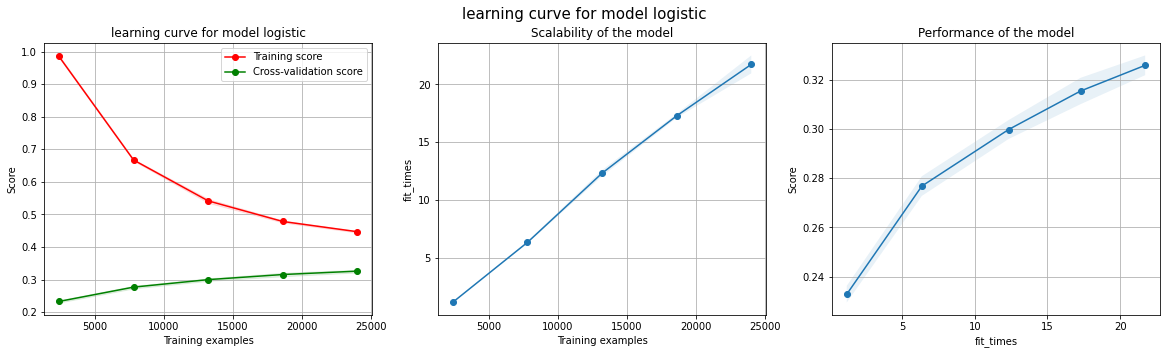

accuracy model logistic : 0.34752681287017767


,precision,recall,f1-score,support
.net,0.582524,0.101180,0.172414,593.0
algorithm,0.772251,0.549348,0.642002,537.0
android,0.933032,0.755311,0.834818,1365.0
angular,0.788079,0.481781,0.597990,247.0
angularjs,0.876106,0.482927,0.622642,205.0
arrays,0.618123,0.436073,0.511379,438.0
asp.net,0.597561,0.231132,0.333333,212.0
bash,0.777778,0.526012,0.627586,173.0
c,0.639881,0.352170,0.454305,1221.0
c#,0.730442,0.401027,0.517782,2142.0


In [ ]:
display(algo_estimator.getPredictionsResult( "logistic", X_test).sample(10))
algo_estimator.getLearningCurveByName('logistic',X_train[0:30000],y_train[0:30000])
algo_estimator.getClassificationReport("logistic",y_test,X_test)

**Random Forest** : C'est une technique à base d'arbres qui utilise un très grand nombre d'arbres de décisions construits à partir d'ensembles de caractéristiques aléatoirement sélectionnés. Contrairement à un simple arbre de décision, il n'est pas interprétable du tout mais le fait qu'il ait une bonne performance en fait un algorithme populaire.

,True_Tag,predicted_Tag
10744,"(haskell,)",()
13263,"(c, c++, pointers)","(c, c++, pointers)"
8495,"(android,)","(android,)"
11858,"(css, html, javascript)","(css, html, javascript)"
3287,"(javascript, jquery, typescript)",()
10528,"(html, javascript, php)","(html, jquery)"
18070,"(ruby-on-rails,)",()
3531,"(windows,)",()
12514,"(git,)","(git,)"
16298,"(ios, xcode)","(ios, xcode)"


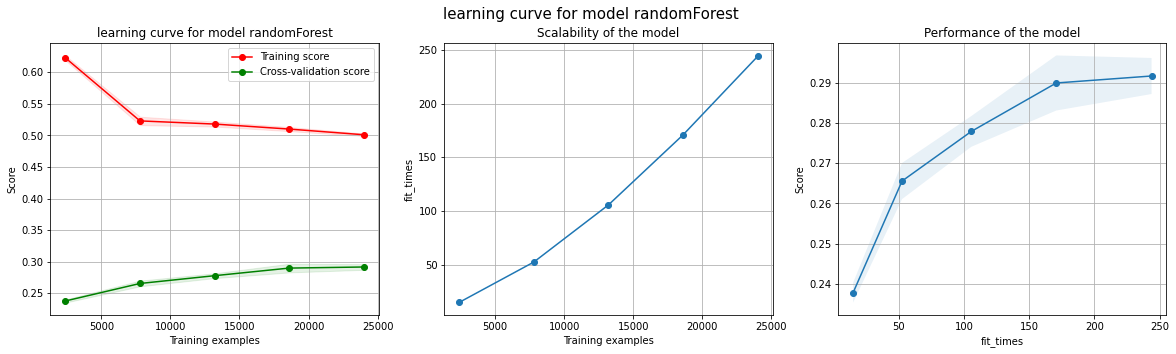

accuracy model randomForest : 0.26658129235366307


,precision,recall,f1-score,support
.net,0.380165,0.232715,0.288703,593.0
algorithm,0.575163,0.655493,0.612707,537.0
android,0.783333,0.791941,0.787614,1365.0
angular,0.699387,0.461538,0.556098,247.0
angularjs,0.304762,0.156098,0.206452,205.0
arrays,0.422553,0.778539,0.547791,438.0
asp.net,0.513699,0.353774,0.418994,212.0
bash,0.726190,0.352601,0.474708,173.0
c,0.408319,0.570844,0.476093,1221.0
c#,0.496086,0.562092,0.527030,2142.0


In [ ]:
display(algo_estimator.getPredictionsResult( "randomForest", X_test).sample(10))
algo_estimator.getLearningCurveByName('randomForest',X_train[0:30000],y_train[0:30000])
algo_estimator.getClassificationReport("randomForest",y_test,X_test)

Le modele **SGDClassifier** implémente une routine d'apprentissage de descente de gradient stochastique simple qui prend en charge différentes fonctions de perte et pénalités pour la classification.

La descente de gradient stochastique (SGD) est une approche simple mais très efficace pour ajuster les classificateurs linéaires et les régresseurs sous des fonctions de perte convexes telles que les machines à vecteurs de support (linéaires) et la régression logistique . Même si SGD existe depuis longtemps dans la communauté de l'apprentissage automatique, il a récemment reçu une attention considérable dans le contexte de l'apprentissage à grande échelle.


Les avantages de Stochastic Gradient Descent sont :

Efficacité.

Facilité de mise en œuvre (nombreuses possibilités de réglage du code).

Les inconvénients de Stochastic Gradient Descent incluent :

SGD nécessite un certain nombre d'hyperparamètres tels que le paramètre de régularisation et le nombre d'itérations.

SGD est sensible à la mise à l'échelle des fonctionnalités.



,True_Tag,predicted_Tag
8809,"(java,)","(java,)"
9339,"(r,)",()
177,"(c#,)",()
3728,"(angular,)",()
16133,"(php,)",()
13858,"(javascript,)","(javascript,)"
3620,"(c#,)","(json,)"
15587,"(java,)","(c++, java)"
5357,"(android,)","(android,)"
7285,"(c++,)","(c++,)"


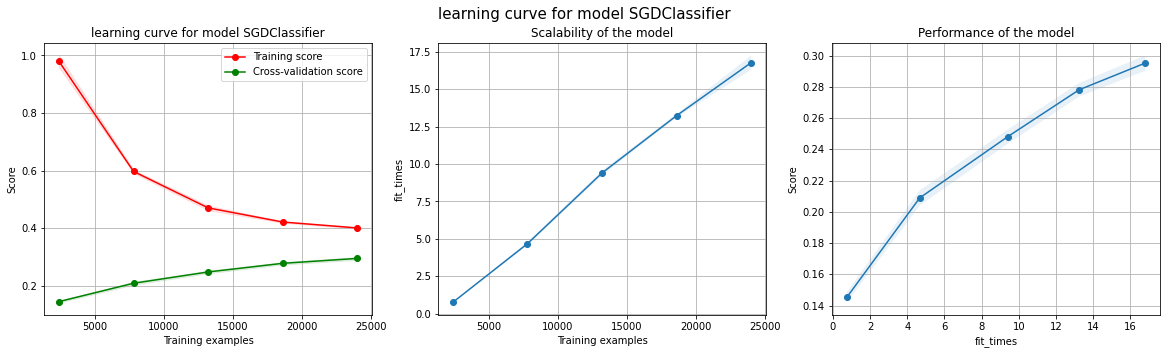

accuracy model SGDClassifier : 0.32447574835921245


,precision,recall,f1-score,support
.net,0.423810,0.150084,0.221669,593.0
algorithm,0.727689,0.592179,0.652977,537.0
android,0.899476,0.753846,0.820247,1365.0
angular,0.802817,0.461538,0.586118,247.0
angularjs,0.756098,0.453659,0.567073,205.0
arrays,0.595318,0.406393,0.483039,438.0
asp.net,0.547826,0.297170,0.385321,212.0
bash,0.581921,0.595376,0.588571,173.0
c,0.559322,0.351351,0.431590,1221.0
c#,0.628922,0.430439,0.511086,2142.0


In [ ]:
display(algo_estimator.getPredictionsResult( "SGDClassifier", X_test).sample(10))
algo_estimator.getLearningCurveByName('SGDClassifier',X_train[0:30000],y_train[0:30000])
algo_estimator.getClassificationReport("SGDClassifier",y_test,X_test)

Ce classificateur convertit d'abord les valeurs cibles  puis traite le problème comme une tâche de régression (régression multi-sorties dans le cas multiclasse)

Pour la classification multi-classes, les classificateurs n_class sont entraînés dans une approche un contre tous. Concrètement, cela est mis en œuvre en tirant parti de la prise en charge de la réponse multivariée dans Ridge.



,True_Tag,predicted_Tag
13323,"(android,)",()
17044,"(c,)",()
5265,"(python,)","(python,)"
17793,"(javascript,)","(css, javascript)"
12439,"(bash,)","(bash,)"
1080,"(java,)","(java,)"
12479,"(java,)",()
13552,"(python,)",()
15178,"(asp.net, c#)",()
3594,"(c#, visual-studio)",()


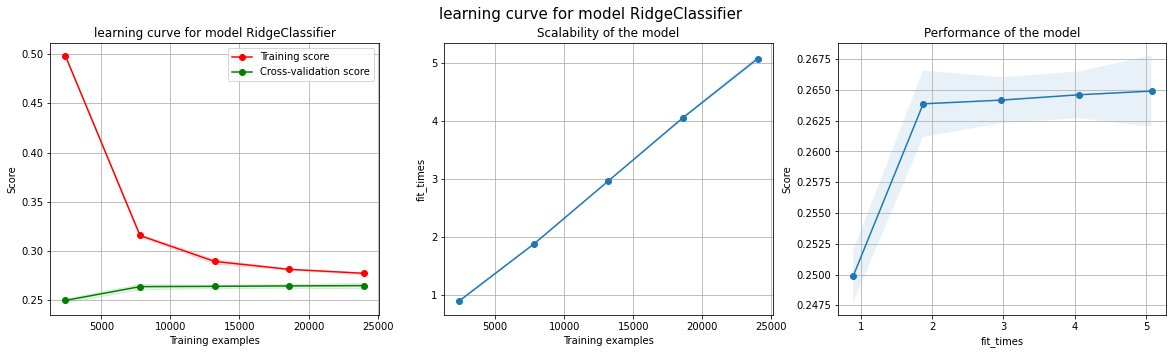

accuracy model RidgeClassifier : 0.2603916546609039


,precision,recall,f1-score,support
.net,0.600000,0.055649,0.101852,593.0
algorithm,0.807882,0.305400,0.443243,537.0
android,0.968215,0.580220,0.725607,1365.0
angular,0.796296,0.348178,0.484507,247.0
angularjs,0.984615,0.312195,0.474074,205.0
arrays,0.617530,0.353881,0.449927,438.0
asp.net,0.593220,0.165094,0.258303,212.0
bash,0.817073,0.387283,0.525490,173.0
c,0.661765,0.147420,0.241125,1221.0
c#,0.787307,0.214286,0.336881,2142.0


In [ ]:
display(algo_estimator.getPredictionsResult( "RidgeClassifier", X_test).sample(10))
algo_estimator.getLearningCurveByName('RidgeClassifier',X_train[0:30000],y_train[0:30000])
algo_estimator.getClassificationReport("RidgeClassifier",y_test,X_test)

Comme enonce precedemment , nous n allons pas garder ces modeles pour notre selection 

<div class="bg-primary text-lg-left text-white">
    <div>
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          API disponlible
        </h1>
    </div>

</div>
    <div class="text-lg-left ">
       <a href="https://github.com/ismailazdad/stackoverflowTags" target="_blank">stackoverflow</a>
    </div>
     <div>       
       <a href="http://ismail2233.pythonanywhere.com/" target="_blank">online version</a>
    </div>



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
y_test_predicted_labels = algo_estimator.grid_searches['logistic'].predict(X_test)   
print(multilabel_confusion_matrix(y_test, y_test_predicted_labels))

[[[18105    43]
  [  533    60]]

 [[18117    87]
  [  242   295]]

 [[17302    74]
  [  334  1031]]

 [[18462    32]
  [  128   119]]

 [[18522    14]
  [  106    99]]

 [[18185   118]
  [  247   191]]

 [[18496    33]
  [  163    49]]

 [[18542    26]
  [   82    91]]

 [[17278   242]
  [  791   430]]

 [[16282   317]
  [ 1283   859]]

 [[15618   536]
  [ 1213  1374]]

 [[18201    56]
  [  417    67]]

 [[17893    91]
  [  209   548]]

 [[18499    41]
  [   94   107]]

 [[18420    22]
  [   24   275]]

 [[18517    43]
  [   81   100]]

 [[18558    16]
  [   48   119]]

 [[17633   191]
  [  510   407]]

 [[17693   168]
  [  358   522]]

 [[18535    40]
  [  130    36]]

 [[16380   140]
  [  963  1258]]

 [[18551    26]
  [  102    62]]

 [[16147   318]
  [ 1090  1186]]

 [[17985    74]
  [  301   381]]

 [[18455    32]
  [   96   158]]

 [[18474    45]
  [  164    58]]

 [[18412    38]
  [  227    64]]

 [[18561    24]
  [  110    46]]

 [[18432    52]
  [  136   121]]

 [[18317    58

In [ ]:
X_test.shape

(18741, 2)

Word2vec